In [40]:
import sys
import astro_models
import numpy as np
import matplotlib.pyplot as plt
import pickle, os
import batman
import emcee
import astropy
from astropy.time import Time
import h5py
import corner
from matplotlib.ticker import MaxNLocator, ScalarFormatter
from astropy.timeseries import LombScargle
import astropy.units as u
import scipy.signal as signal

In [2]:
# load MCMC results
pathchain = 'MCMC_results/samplerchain_10000.npy'
pathlnlchain = 'MCMC_results/samplerlnlchain_10000.npy'
pathposit = 'MCMC_results/samplerposi_10000.npy'
pathlnpro = 'MCMC_results/samplerlnpr_10000.npy'
chain = np.load(pathchain)
lnprobchain = np.load(pathlnlchain)
pos2 = np.load(pathposit)
prob = np.load(pathlnpro)

In [18]:
aperture = ['4']
#aperture = ['4', '7', '12']
segments = ['0000', '0001', '0002', '0003', '0004']

# Initialize dictionaries to hold arrays for each aperture
time = {a: [] for a in aperture}
aplev = {a: [] for a in aperture}
aperr = {a: [] for a in aperture}
centroid_x = {a: [] for a in aperture}
centroid_y = {a: [] for a in aperture}

for a in aperture:
    for seg in segments:
        path = '/Volumes/HardDrive/LHS1140-c/JWST_eclipse1/LHS1140c-S3_ap' + a + '_bg12_30/S3_lhs1140c_ap' + a + '_bg12_30_FluxData_seg'+seg+'.h5'
        with h5py.File(path, 'r') as file:     # open the file
            time[a] = np.append(time[a], np.array(file['time']))
            aplev[a] = np.append(aplev[a], np.array(file['aplev']))
            aperr[a] = np.append(aperr[a], np.array(file['aperr']))
            centroid_x[a] = np.append(centroid_x[a], np.array(file['centroid_x']))
            centroid_y[a] = np.append(centroid_y[a], np.array(file['centroid_y']))

    time[a] = np.array(time[a])
    aplev[a] = np.array(aplev[a])
    aperr[a] = np.array(aperr[a])
    centroid_x[a] = np.array(centroid_x[a])
    centroid_y[a] = np.array(centroid_y[a])
    
print(time['4'])

[60275.77646891 60275.77659717 60275.77672543 ... 60275.93794689
 60275.93807515 60275.93820341]


In [19]:
time = time['4'][200:]
aplev = aplev['4'][200:]
aperr = aperr['4'][200:]
centroid_x = centroid_x['4'][200:]
centroid_y = centroid_y['4'][200:]

aplev     = aplev/np.mean(aplev)
aperr     = aperr/np.mean(aperr)

(0.997, 1.003)

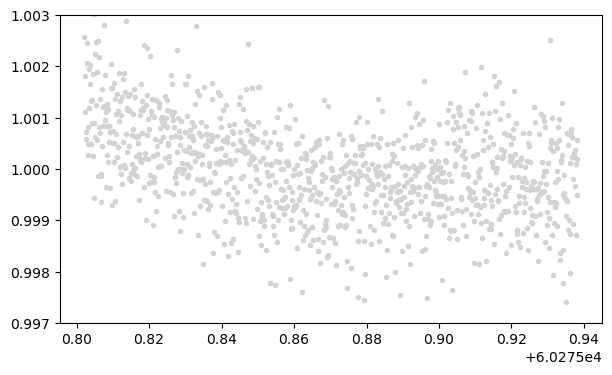

In [21]:
plt.figure(figsize = [7,4])
plt.plot(time, aplev, color = 'lightgrey', marker = '.', linestyle = 'None')
plt.ylim(0.997,1.003)

In [38]:
def detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6):
    """Model the detector systematics with a 2D polynomial model based on the centroid.
    Args:
        detec_inputs (tuple): (x, y, mode) with dtypes (ndarray, ndarray, string). Formatted this
            way to allow for easy minimization with scipy.optimize.minimize.
        c1--c21 (float): The polynomial model amplitudes.
    Returns:
        ndarray: The flux variations due to the detector systematics.
    """

    x, y = xdata, ydata
    pos = np.vstack((np.ones_like(x),
                     x   ,      y,
                     x**2, x   *y,      y**2))
    detec = np.array([c1, c2, c3, c4, c5, c6])
    return np.dot(detec[np.newaxis,:], pos).reshape(-1)

def transit_model(time, t_s, fp):
    params = batman.TransitParams()       #object to store transit parameters
    params.t0 = 58388.7939                #time of inferior conjunction
    params.per = 3.777940                 #orbital period
    params.rp = 0.05486                   #planet radius (in units of stellar radii)
    params.a = 26.57                      #semi-major axis (in units of stellar radii)
    params.inc = 89.8                     #orbital inclination (in degrees)
    params.ecc = 0.                       #eccentricity
    params.w = 90.                        #longitude of periastron (in degrees)
    params.limb_dark = "quadratic"        #limb darkening model
    params.u = [0.16, 0.22]               #limb darkening coefficients, values from cadieux 2024b
    params.fp = fp                        #planet to star flux ratio
    params.t_secondary = t_s

    m = batman.TransitModel(params, time, transittype="secondary")
    flux = m.light_curve(params)
    return flux

def signals(time, xdata, ydata, t_s, fp, c1, c2, c3, c4, c5, c6):

    astro = transit_model(time, t_s, fp)
    detec = detec_model_poly(xdata, ydata, c1, c2, c3, c4, c5, c6)

    return astro*detec

In [24]:
# initialize parameters
t_0 = 58388.7939
per = 3.777940
rp = 0.05486
a = 26.57
inc = 89.8
ecc = 0
w = 90
fp = 0.000230
t_s = 60275.875

p0_astro = np.array([t_s, fp])
p0_detec = np.array([0.5, 0.1, 0.1, -0.1, 0.1, 0.1])
p0 = np.concatenate((p0_astro, p0_detec, [0.001]))
nsteps, nwalkers, ndim = 10000, 50, len(p0)

In [35]:
samples = chain.reshape((-1, ndim))

MCMC_Results = np.array(list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84],axis=0)))))

maxk, maxiter = np.unravel_index((lnprobchain).argmax(), (lnprobchain).shape)
p0_mcmc = chain[maxk, maxiter,:]
for i in range(len(p0_mcmc)):
    MCMC_Results[i] = (p0_mcmc[i], MCMC_Results[i][1], MCMC_Results[i][2])

p0_labels = ['t_s','fp', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'sigF']

out = "MCMC result:\n\n"
for i in range(len(p0_mcmc)):
    out += '{:>8} = {:>16}  +{:>16}  -{:>16}\n'.format(p0_labels[i],MCMC_Results[i][0], MCMC_Results[i][1], MCMC_Results[i][2])
print(out, flush=True)

MCMC result:

     t_s = 60275.875009902804  +3.950276004616171e-05  -3.9974656829144806e-05
      fp = 0.0005661522322664744  +5.785961593619154e-05  -5.756880696813492e-05
     c_1 = 17730.416599415825  +108612.55927736592  -100067.32002473425
     c_2 = -577.3964182724981  +1054.3949354097622  -1123.927909842413
     c_3 = 299.19505252170916  +744.2669008025866  -747.3005481276974
     c_4 = 3.3211362314861095  +3.2486184249070345  -3.1475749619459314
     c_5 = -2.095418597080444  +3.770569313694578  -3.6953771219296794
     c_6 = -0.13441836110831995  +1.7021878626366225  -1.6723932426099455
    sigF = 0.0008645465418480156  +1.9510954200001166e-05  -1.848751295066781e-05



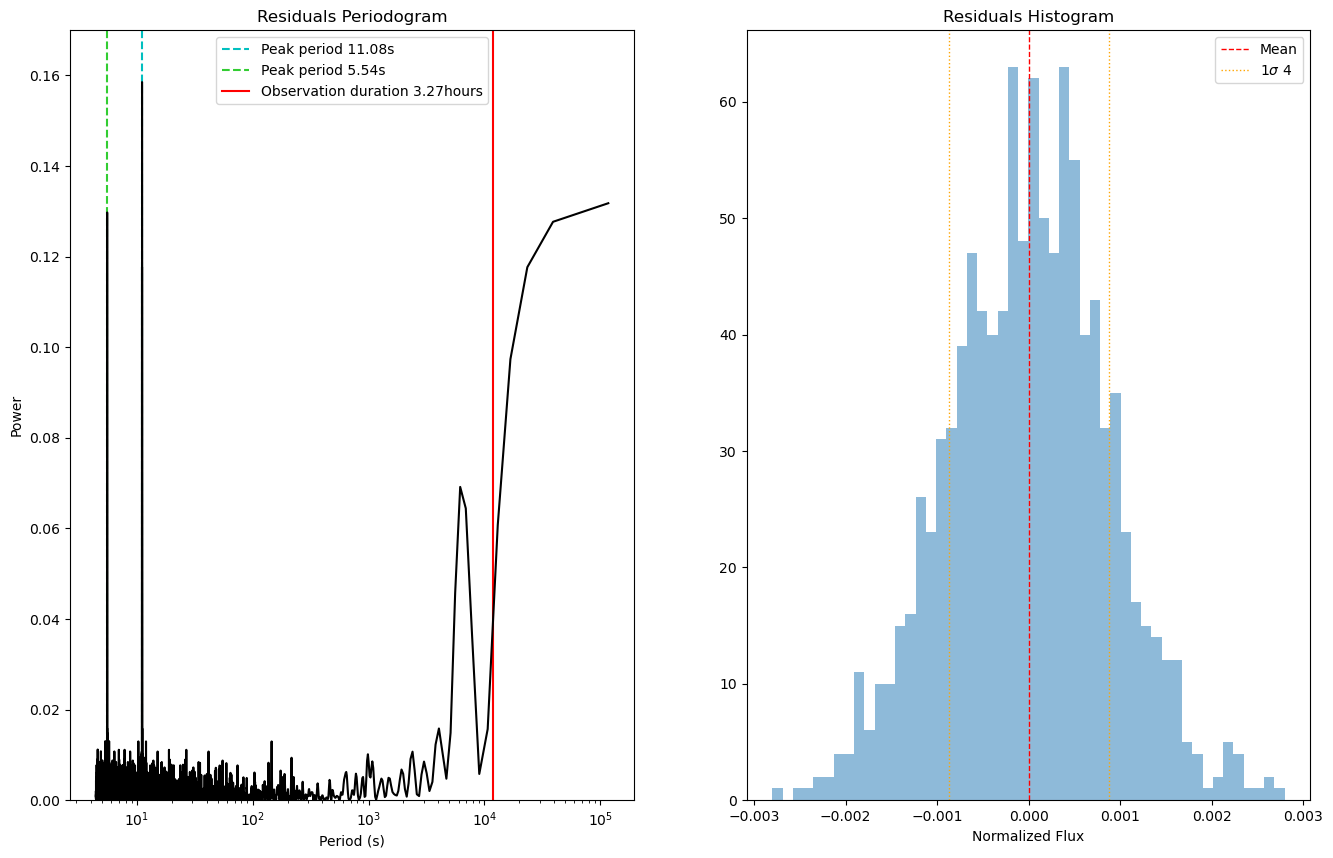

In [46]:
t_s, fp, c1, c2, c3, c4, c5, c6, sigF = p0_mcmc
astro = transit_model(time, t_s, fp)
detec = detec_model_poly(centroid_x, centroid_y, c1, c2, c3, c4, c5, c6)
residuals = (aplev/detec) - astro

frequency, power = LombScargle(time, residuals).autopower()
period = (1/frequency)*(24*60*60)

dt = (time[2]-time[1])*24*60*60 # in seconds

fig, ax = plt.subplots(1,2)
#adjust figsize
fig.set_figheight(10)
fig.set_figwidth(16)

# residuals
peak_indices, z = signal.find_peaks(np.array(power), height = 0.1)
colors = ['c', 'limegreen', 'magenta']
c=0
for i in range(0,len(peak_indices)-1):
         if i == 0 or np.floor(period[peak_indices[i]]) != np.floor(period[peak_indices[i-1]]) :
            #color = colors[i % len(colors)]  # Cycle through colors
            label = f"Peak period {period[peak_indices[i]]:.2f}s"           
            ax[0].axvline(x=period[peak_indices[i]],linestyle='--', color = colors[c], label = label)
            c+=1

ax[0].axvline(x=len(time)*dt, color='red', label=f"Observation duration {len(time)*dt/(60*60):.2f}hours")


ax[0].plot(period, power, color = 'k') # convert frequency to period in seconds

ax[0].set_xscale('log')
ax[0].set_title('Residuals Periodogram')
ax[0].set_ylim(0,0.17)
ax[0].set_xlabel('Period (s)')
ax[0].set_ylabel('Power')

# residuals histogram
ax[1].hist(residuals, bins=50, alpha=0.5)

ax[1].axvline(x=np.mean(residuals), color='red', linestyle='dashed', linewidth=1, label='Mean')

ax[1].axvline(x=np.mean(residuals)+np.std(residuals), color='orange', linestyle='dotted', linewidth=1, label='1$\sigma$ 4')
ax[1].axvline(x=np.mean(residuals)-np.std(residuals), color='orange', linestyle='dotted', linewidth=1)

ax[1].set_title('Residuals Histogram')
ax[1].set_xlabel('Normalized Flux')
#ax[1].set_xlim(0.996, 1.004)

ax[0].legend()
ax[1].legend()

plt.savefig('figs/MCMC_residuals_hist_period.png')

# duration of observation is for considered observation i.e. first 36 mins ignored

(array([ 3.,  8., 19., 41., 60., 69., 57., 40., 20.,  9.]),
 array([-0.00175353, -0.00143278, -0.00111204, -0.00079129, -0.00047055,
        -0.0001498 ,  0.00017094,  0.00049169,  0.00081243,  0.00113318,
         0.00145392]),
 <BarContainer object of 10 artists>)

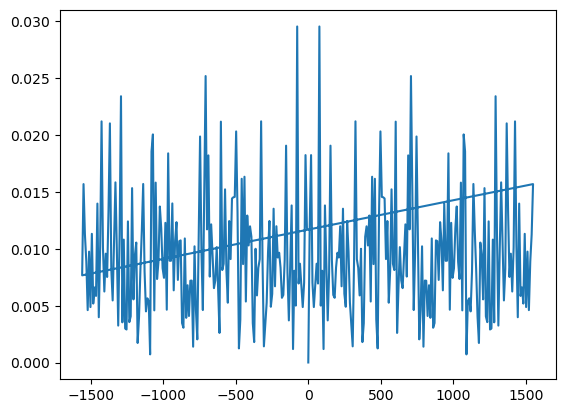

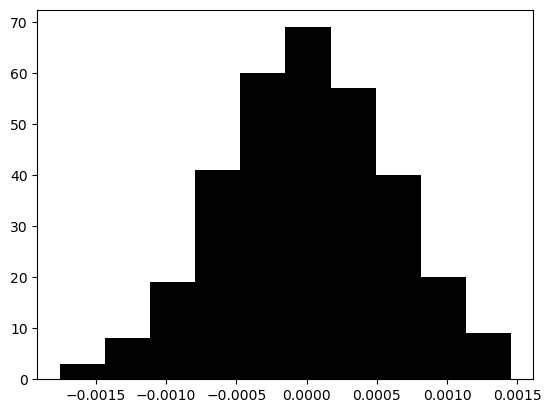

In [83]:
# define residuals

f_corr = f/degree2_slope(t, a, b, c)
residuals = f - degree2_slope(t, a, b, c)

# periodogram
strain = np.fft.fft(residuals)
freq = np.fft.fftfreq(len(residuals), d = t[1]-t[0])

plt.figure()
plt.plot(freq, np.abs(strain))

# histogram
plt.figure()
plt.hist(residuals, bins = 10, color = 'black')


/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_82969/2484989397.py:14: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)
/var/folders/19/ynl_hkyx385cs4g05ztfqxfr0000gp/T/ipykernel_82969/2484989397.py:14: RankWarning: Polyfit may be poorly conditioned
  a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)


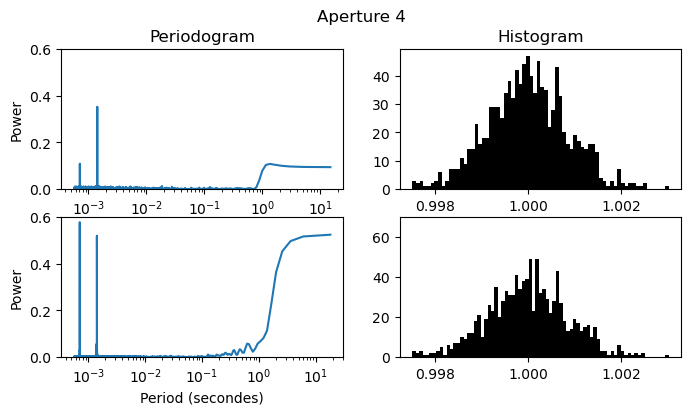

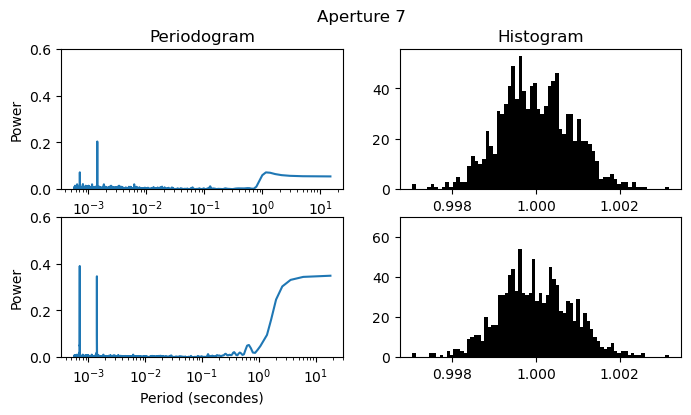

In [227]:
# stats on residuals compared to full data
# residuals are defined as normalized, first 200 pts removed, eclipse removed, trend removed
residuals = {a: [] for a in aperture}
raw = {a: [] for a in aperture} # raw is normalized, first 200 pts removed

for ap in aperture:
    # binned
    # t = bins_time[ap]
    # a, b, c = np.polyfit(bins_time[ap], bins_aplev[ap], 2)
    # residuals = bins_aplev[ap]/degree2_slope(bins_time[ap], a, b, c)

    # unbinned
    t = short_time[ap]
    a, b, c = np.polyfit(short_time[ap], norm_aplev[ap], 2)
    residuals[ap] = norm_aplev[ap]/degree2_slope(short_time[ap], a, b, c)

    # plot periodogram and histogram
    fig, ax = plt.subplots(2,2)
    #adjust figsize
    fig.set_figheight(4)
    fig.set_figwidth(8)
    # add title
    fig.suptitle('Aperture ' + ap)

    # periodogram
    # strain = np.fft.fft(residuals)
    # freq = np.fft.fftfreq(len(residuals), d = t[1]-t[0])
    # ax[0,0].plot(freq, np.abs(strain))
    frequency, power = LombScargle(t, residuals[ap]).autopower()
    ax[0,0].plot((1/(frequency/0.00012825))*(24*60*60), power)
    ax[0,0].set_xscale('log')
    #ax[0,0].plot(frequency, power)
    ax[0,0].set_title('Periodogram')
    ax[0,0].set_ylim(0, 0.6)
    #ax[0,0].set_xlim(-0.00001, 0.00022)

    # histogram
    ax[0,1].hist(residuals[ap], bins = 70, color = 'black')
    ax[0,1].set_title('Histogram')
    # set ylim
    #ax[0,1].set_ylim(0, 70)

    # Compare with full data
    ax[0,0].set_ylabel('Power')
    ax[1,0].set_ylabel('Power')
    # ax[1,0].set_ylabel('Full signal')
    # ax[0,0].set_title('Detrended flux')

    # raw / full
    t = time[ap]
    raw[ap] = aplev[ap] / np.mean(aplev[ap])

    # periodogram
    # strain = np.fft.fft(aplev)
    # freq = np.fft.fftfreq(len(aplev), d = t[1]-t[0])
    # ax[1,0].plot(freq, np.abs(strain))
    frequency, power = LombScargle(t, raw[ap]).autopower()
    ax[1,0].plot((1/(frequency/0.00012825))*(24*60*60), power)
    ax[1,0].set_xscale('log')
#    ax[1,0].set_xlabel('Period (days)')
    ax[1,0].set_xlabel('Period (secondes)')
    #ax[1,0].set_xlim(-0.00001, 0.00022)
    #set y limits
    ax[1,0].set_ylim(0, 0.6)
    # frequencies of oscillation (i.e., number of cycles per unit time).

    # histogram
    ax[1,1].hist(residuals[ap], bins = 75, color = 'black')
    # set ylim
    ax[1,1].set_ylim(0, 70)
    #save fig
    plt.savefig('figs/Aperture' + ap + '.pdf')

# std deviation and comparison with other apertures
# use boxcar to smooth data (convolve with boxcar) to remove all signal and see scatter and use that as residuals


In [226]:
print('Residuals:')
for ap in aperture:
    print('Aperture: ', ap, '\n mean: ', np.mean(residuals[ap]), '\n std: ', np.std(residuals[ap]))

print('\nRaw:')
for ap in aperture:
    print('Aperture: ', ap, '\n mean: ', np.mean(raw[ap]), '\n std: ', np.std(raw[ap]))
    print(' Mean errorbar: ', np.mean(norm_aperr[ap]), ' \n Std errorbar: ', np.std(norm_aperr[ap]), '\n')

# these are all normalized, residuals are normalized before removing eclipse
# errorbars are calculated at each point but have very small
# Standard deviation of residuals is higher than errorbars

Residuals:
Aperture:  4 
 mean:  1.0000000000244904 
 std:  0.0008558676513334198
Aperture:  7 
 mean:  1.000000000006963 
 std:  0.0008789057180248371

Raw:
Aperture:  4 
 mean:  1.0 
 std:  0.0012714981347602423
 Mean errorbar:  0.0006667742427888127  
 Std errorbar:  2.9206476081306554e-07 

Aperture:  7 
 mean:  1.0 
 std:  0.0011432418929773602
 Mean errorbar:  0.0006874625238642792  
 Std errorbar:  2.1699044704454027e-07 



Text(0.5, 0, 'Frequency (cycles/0.00012825 days)')

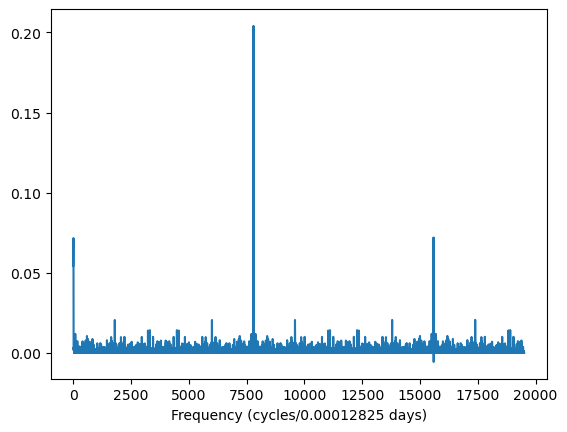

In [231]:
frequency, power = LombScargle(short_time[ap], residuals[ap]).autopower()
plt.plot(frequency, power)  
plt.xlabel('Frequency (cycles/0.00012825 days)')
# 0.00012825 days is equivalent to 11s

In [232]:
print(t[501]-t[500])
print(0.00012825 * 24 * 60 * 60) # every ~11 seconds
print((t[-1]-t[0])/len(t))
print(len(short_time['7'])) 
# unit is per 0.00012825 days

0.0001282589219044894
11.0808
0.0001281572903772405
1062


In [134]:
print('4 mean error: ', np.mean(norm_aperr['4']))
print('7 mean error', np.mean(norm_aperr['7']))
print('4 std: ', np.std(norm_aperr['4']))
print('7 std: ', np.std(norm_aperr['7']))

# check to verify array with eclipse gives same OOM
# test = aperr['4'] / np.mean(aplev['4'])
# print(np.mean(test))
# print(np.std(test))


4 mean error:  0.0006667742427888127
7 mean error 0.0006874625238642792
4 std:  2.9206476081306554e-07
7 std:  2.1699044704454027e-07
0.0006668677022191062
3.4415687365944937e-07


In [61]:
def binValues(values, binAxisValues, nbin, assumeWhiteNoise=False, errorbars = False):
    """Bin values and compute their binned noise.

    Args:
        values (ndarray): An array of values to bin.
        binAxisValues (ndarray): Values of the axis along which binning will occur.
        nbin (int): The number of bins desired.
        assumeWhiteNoise (bool, optional): Divide binned noise by sqrt(nbinned) (True) or not (False, default).

    Returns:
        tuple: binned (ndarray; the binned values),
            binnedErr (ndarray; the binned errors)
    
    """
    
    bins = np.linspace(np.nanmin(binAxisValues), np.nanmax(binAxisValues), nbin)
    digitized = np.digitize(binAxisValues, bins)
    if errorbars == True:
        binned = np.array([np.nanmean(values[digitized == i]) for i in range(1, nbin)])
        binned = binned/np.sqrt(len(values)/nbin)
    else:
        binned = np.array([np.nanmedian(values[digitized == i]) for i in range(1, nbin)])    
    binnedErr = np.nanmean(np.array([np.nanstd(values[digitized == i]) for i in range(1, nbin)]))

    if assumeWhiteNoise:
        binnedErr /= np.sqrt(len(values)/nbin)
    return binned, binnedErr